In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.utils import create_data

from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

(70000, 784)
(70000,)


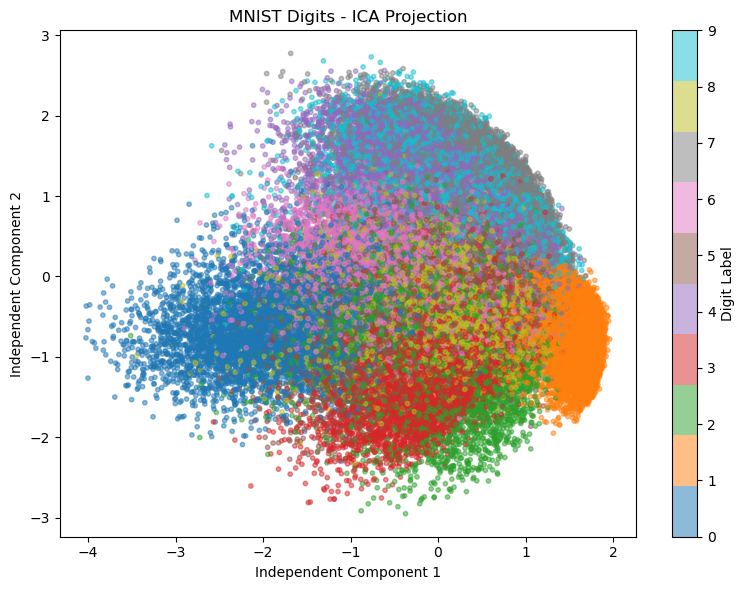

In [4]:
X, y = create_data()
random_state = 42

scaler = StandardScaler(with_std=False)
X_centered = scaler.fit_transform(X)

# ==========================
# 1. ICA - Observations
# ==========================
ica = FastICA(n_components=2, random_state=random_state, max_iter=500)
X_ica = ica.fit_transform(X_centered)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_ica[:, 0], X_ica[:, 1], c=y, cmap="tab10", s=10, alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("Independent Component 1")
plt.ylabel("Independent Component 2")
plt.title("MNIST Digits - ICA Projection")
plt.tight_layout()
plt.savefig("docs/ica12_labeled.png")
plt.show()

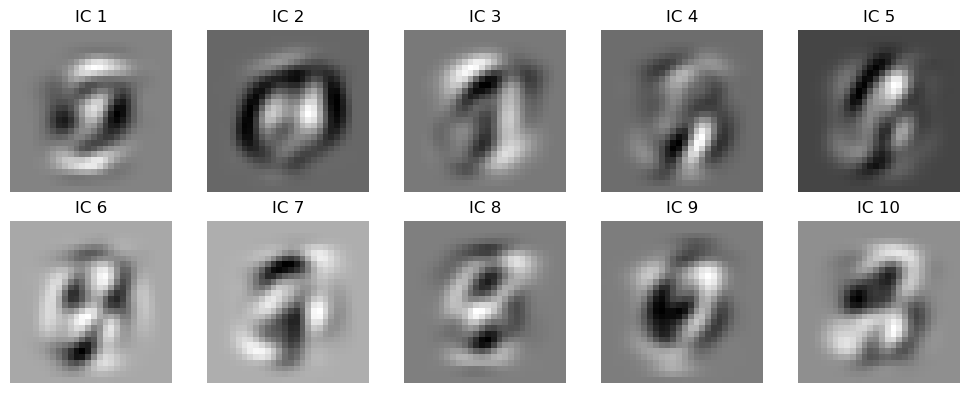

In [5]:
# ==========================
# 2. ICA - Feature Patterns
# ==========================
ica = FastICA(n_components=10, random_state=random_state, max_iter=500)
Z = ica.fit_transform(X_centered)
components = ica.components_

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"IC {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.savefig("docs/ica_feature_patterns.png")
plt.show()

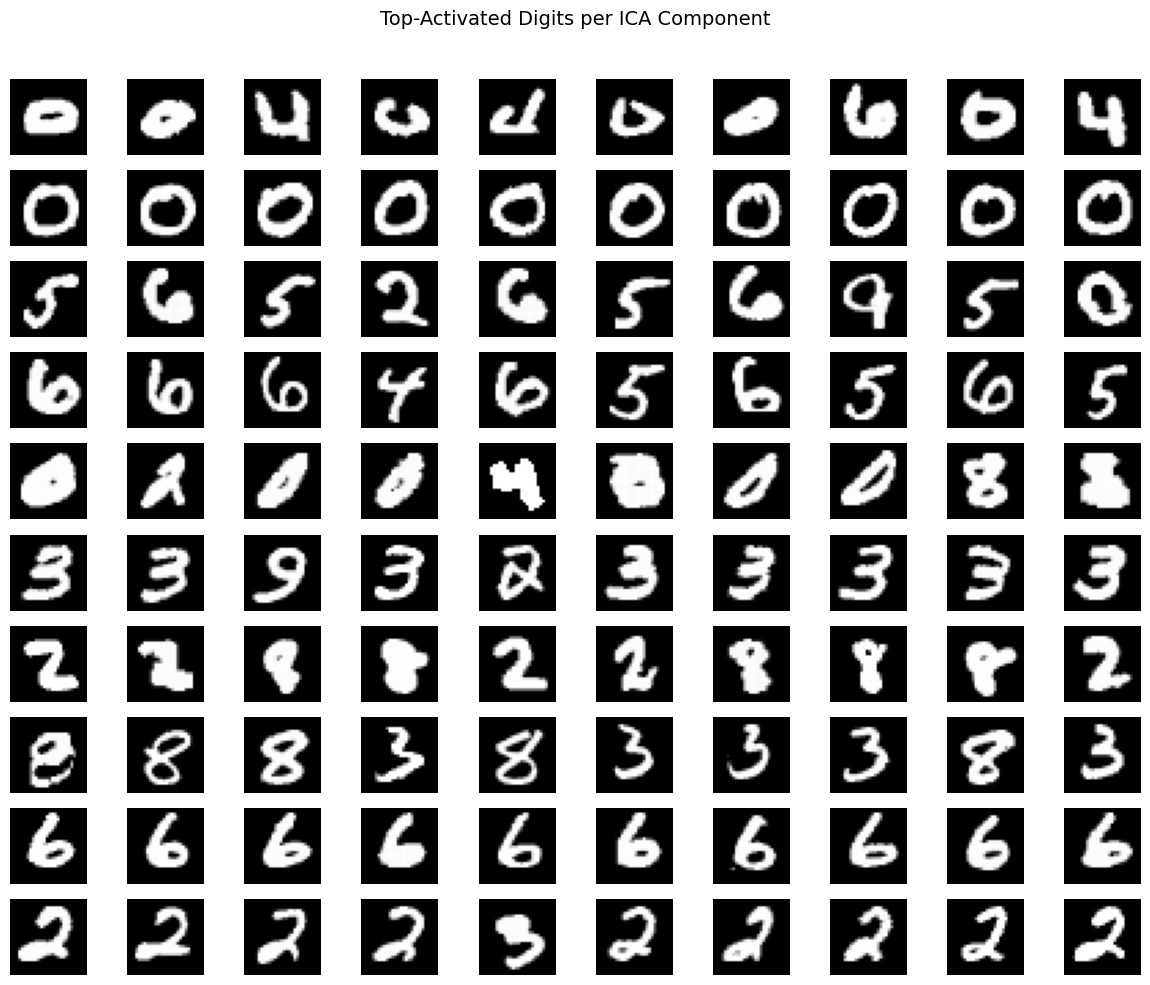

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# --- Fit ICA with 10 components ---
ica = FastICA(n_components=10, random_state=random_state, max_iter=500)
Z = ica.fit_transform(X_centered)  # activations (mixing coefficients)
components = ica.components_

# --- For visualization, take absolute activations (strong positive or negative) ---
Z_strength = np.abs(Z)

# --- Select top-k most strongly activated digits per component ---
top_k = 10
fig, axes = plt.subplots(10, top_k, figsize=(12, 10))

for i in range(10):
    top_idx = np.argsort(Z_strength[:, i])[::-1][:top_k]
    for j, idx in enumerate(top_idx):
        axes[i, j].imshow(X.iloc[idx].to_numpy().reshape(28, 28), cmap="gray")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(f"IC {i+1}", rotation=0, labelpad=20)

plt.suptitle("Top-Activated Digits per ICA Component", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("docs/ica_top_activations_grid.png")
plt.show()


ICA iteration complete: k = 5, accuracy = 0.6769


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA iteration complete: k = 10, accuracy = 0.8042


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA iteration complete: k = 15, accuracy = 0.8438
ICA iteration complete: k = 20, accuracy = 0.8761
ICA iteration complete: k = 25, accuracy = 0.8862
ICA iteration complete: k = 30, accuracy = 0.8906
ICA iteration complete: k = 35, accuracy = 0.8939


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA iteration complete: k = 40, accuracy = 0.8972
ICA iteration complete: k = 45, accuracy = 0.9016
ICA iteration complete: k = 50, accuracy = 0.9032
ICA iteration complete: k = 55, accuracy = 0.9052
ICA iteration complete: k = 60, accuracy = 0.9073
ICA iteration complete: k = 65, accuracy = 0.9076
ICA iteration complete: k = 70, accuracy = 0.9086
ICA iteration complete: k = 75, accuracy = 0.9100
ICA iteration complete: k = 80, accuracy = 0.9106
ICA iteration complete: k = 85, accuracy = 0.9123
ICA iteration complete: k = 90, accuracy = 0.9121
ICA iteration complete: k = 95, accuracy = 0.9135
ICA iteration complete: k = 100, accuracy = 0.9144


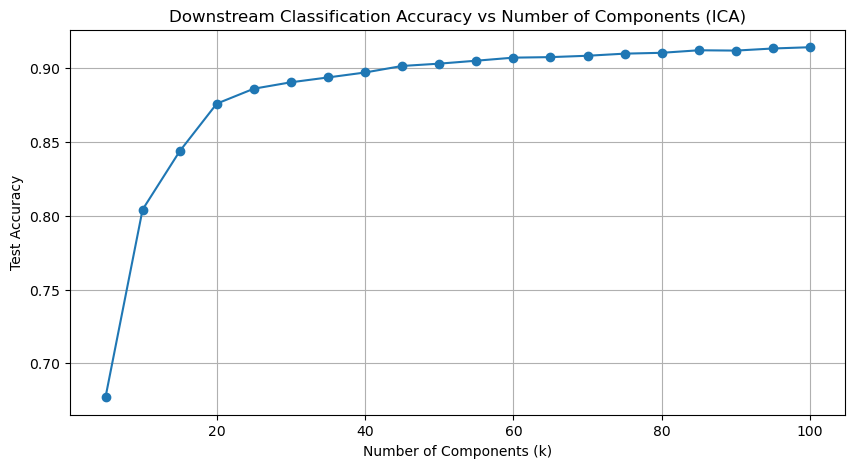

In [8]:
# ==========================
# 3. Hyperparameter Tuning – Supervised
# ==========================
X_tr, X_ts, y_tr, y_ts = train_test_split(X_centered, y, test_size=0.2,
                                          random_state=random_state, stratify=y)
k_list = range(5, 105, 5)
accs = []

for k in k_list:
    ica = FastICA(n_components=k, random_state=random_state, max_iter=500)
    Z_tr = ica.fit_transform(X_tr)
    Z_ts = ica.transform(X_ts)

    scaler = StandardScaler()
    Z_tr_scaled = scaler.fit_transform(Z_tr)
    Z_ts_scaled = scaler.transform(Z_ts)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(Z_tr_scaled, y_tr)
    iteration_acc = accuracy_score(y_ts, clf.predict(Z_ts_scaled))
    accs.append(iteration_acc)
    print(f"ICA iteration complete: k = {k}, accuracy = {iteration_acc:.4f}")

plt.figure(figsize=(10,5))
plt.plot(k_list, accs, marker="o")
plt.xlabel("Number of Components (k)")
plt.ylabel("Test Accuracy")
plt.title("Downstream Classification Accuracy vs Number of Components (ICA)")
plt.grid(True)
plt.savefig("docs/hyperparam_tune_supervised_ica.png")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 250 reached. Increase it to improve convergence.
  warnings.warn(


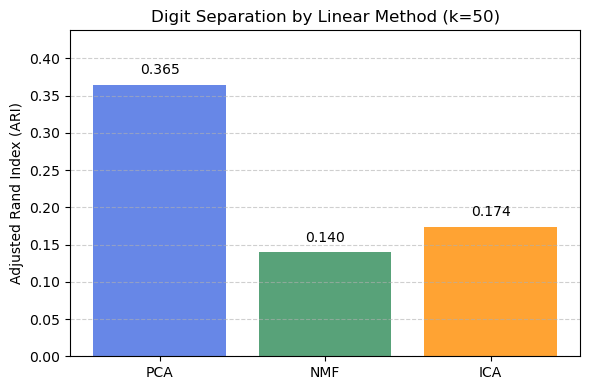

PCA  ARI: 0.365
NMF  ARI: 0.140
ICA  ARI: 0.174


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

random_state = 42
k = 50  # number of components
n_clusters = 10

def compute_ari(Z, y):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    labels = km.fit_predict(Z)
    return adjusted_rand_score(y, labels)

# --- PCA ---
X_centered = StandardScaler(with_std=False).fit_transform(X)
Z_pca = PCA(n_components=k, random_state=random_state).fit_transform(X_centered)
ari_pca = compute_ari(Z_pca, y)

# --- NMF ---
X_nonneg = MinMaxScaler().fit_transform(X)
Z_nmf = NMF(n_components=k, init='nndsvda', random_state=random_state, max_iter=250).fit_transform(X_nonneg)
ari_nmf = compute_ari(Z_nmf, y)

# --- ICA ---
Z_ica = FastICA(n_components=k, random_state=random_state, max_iter=500).fit_transform(X_centered)
ari_ica = compute_ari(Z_ica, y)

# --- Collect results ---
methods = ['PCA', 'NMF', 'ICA']
aris = [ari_pca, ari_nmf, ari_ica]

# --- Barplot ---
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, aris, color=['royalblue', 'seagreen', 'darkorange'], alpha=0.8)
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title(f"Digit Separation by Linear Method (k={k})")
plt.ylim(0, max(aris)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("docs/ari_barplot.png")
plt.show()

print(f"PCA  ARI: {ari_pca:.3f}")
print(f"NMF  ARI: {ari_nmf:.3f}")
print(f"ICA  ARI: {ari_ica:.3f}")